In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import doctest
import copy

In [18]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [30]:
@test 
def bicycle_model(curr_pose, v, delta, dt=1, L =1):
    '''
    >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
    (0.0, 0.0, 0.0) 
    >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
    (1.0, 0.0, 1) 
    '''
    # write code to calculate next_pose
    # refer to the kinematic equations of a bicycle model
    x, y, theta = curr_pose
    x += v*np.cos(theta)*dt
    y += v*np.sin(theta)*dt
    theta += v*np.tan(delta)*dt/L
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x, y, theta

Finding tests in bicycle_model
Trying:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expecting:
    (0.0, 0.0, 0.0) 
**********************************************************************
File "__main__", line 6, in bicycle_model
Failed example:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expected:
    (0.0, 0.0, 0.0) 
Got:
    (0.0, 0.0, 0.0)
Trying:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expecting:
    (1.0, 0.0, 1) 
**********************************************************************
File "__main__", line 8, in bicycle_model
Failed example:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expected:
    (1.0, 0.0, 1) 
Got:
    (1.0, 0.0, 0.9999999999999999)


In [4]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 100
#fill in v and delta values
all_v = np.ones(steps) 
all_delta = np.zeros(steps)
for v, delta in zip(all_v, all_delta):
   #instruction to take v, delta and compute new pose
   straight_trajectory.append(pose)    
   pose = bicycle_model(pose,v,delta)

   # store new pose
straight_trajectory = np.array(straight_trajectory)
    

In [8]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 100  #decreasing dt to 0.1 and increasing steps to 100 for better circular trajectory
#fill in v and delta values
all_v = np.ones(steps) 
all_delta = np.pi/4*np.ones(steps) 
for v, delta in zip(all_v, all_delta):
    #instruction to take v, delta and compute new pose
    circle_trajectory.append(pose)
    pose = bicycle_model(pose, v, delta)
   # store new pose
circle_trajectory = np.array(circle_trajectory)


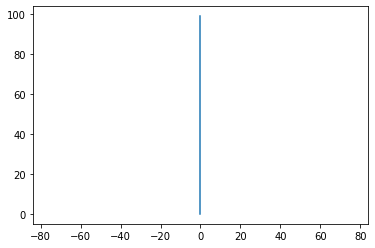

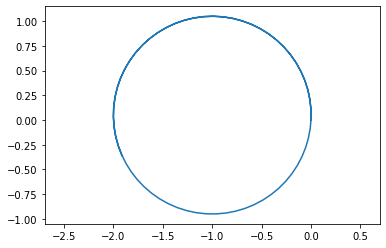

In [9]:
### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0], straight_trajectory[:,1])

plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circle_trajectory[:,0], circle_trajectory[:,1])

### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [23]:
v_c = 1  # m/s
delta_c = np.arctan(np.pi/6) # rad/s
L = 1

#calculate time taken to finish a quarter turn (pi/2)
# unlike you would need to take into account v_c and L of the vehicle as well
t_turn = int(np.pi/2/(v_c*np.tan(delta_c)/L)) 

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/v_c), int(5/v_c), int(8/v_c) 

all_w = [0]*t_straight1 + [-delta_c]*t_turn + \
        [0]*t_straight2 + [delta_c]*t_turn + \
        [0]*t_straight3 + [-delta_c]*t_turn
all_v = v_c*np.ones_like(all_delta)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [31]:
def get_open_loop_commands(route, v_c, delta_c, L = 1):
    all_delta = []
    deltas = {'straight':0, 'left':delta_c, 'right':-delta_c}
    for manoeuvre, command in route:
      u = np.ceil(command/v_c).astype('int')
      v = np.ceil(np.deg2rad(command)/(v_c*np.tan(delta_c)/L)).astype('int')
      t_cmd = u if manoeuvre == 'straight' else v
      all_delta += [deltas[manoeuvre]]*t_cmd
    all_v = v_c*np.ones_like(all_delta)
    return all_v, all_delta

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [33]:
all_v, all_delta = get_open_loop_commands([("straight", 10), ("right", 90), ("straight", 5), ("left", 90), ("straight", 8), ("right", 90)],1 , np.pi/12)

In [32]:
len(all_delta)

41

In [34]:
robot_trajectory = []  ## For this problem, use dt = 1 to get the desired path, otherwise increase the steps accordingly 
pose = np.array([0, 0, np.pi/2])
for v, delta in zip(all_v, all_delta):
    #instruction to take v, delta and compute new pose
    robot_trajectory.append(pose)
    pose = bicycle_model(pose, v, delta)    
   # store new pose
robot_trajectory = np.array(robot_trajectory)

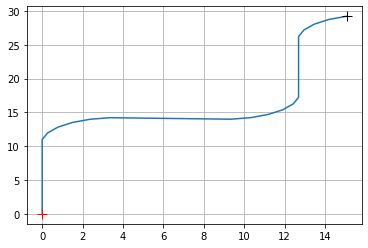

In [35]:
# plot robot trajectory
plt.figure()
plt.grid()
#plt.axes().set_aspect("equal","datalim")
plt.plot(robot_trajectory[:,0], robot_trajectory[:,1] )

#show first and last robot positions with + markers
# example: plt.plot(0, 0, 'r+', ms=10)
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'k+', ms=10)

### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2\theta^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [36]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f

How does a right turn look? 

In [37]:
theta_dot = np.diff(poly_turn(np.pi/2, 0))
print(theta_dot)

[-0.05386819 -0.14436674 -0.20900856 -0.24779366 -0.26072202 -0.24779366
 -0.20900856 -0.14436674 -0.05386819]


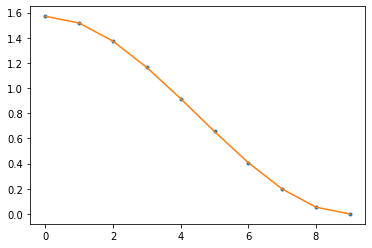

In [38]:
plt.figure()
plt.plot(poly_turn(np.pi/2, 0),'.')
plt.plot(poly_turn(np.pi/2, 0))

Now plot a left turn (North to East)

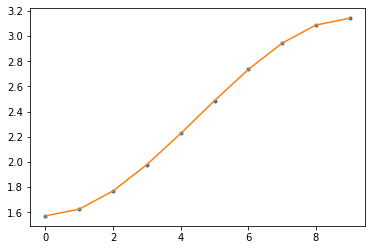

In [ ]:
plt.figure() ## In left turn the orientation of the bot will change from pi/2 to pi
plt.plot(poly_turn(np.pi/2, np.pi),'.')
plt.plot(poly_turn(np.pi/2, np.pi))

How does $\theta$ change when we had constant $\delta$? Plot it

In [40]:
v = 1       ## The bicycle_model can also be used to calculate the all_theta arrray
L = 1
dt = 0.1
delta = np.pi/4 #choosing a constant value of delta
theta_dot = v/L*np.tan(delta)
all_theta = []
theta = np.pi/2 
for i in range(100):
  all_theta.append(theta)
  theta += theta_dot*dt
  theta = np.arctan2(np.sin(theta), np.cos(theta))

print(all_theta)

##NOTE = arctan2 has been used to keep the value of theta between -pi to pi
##For plotting the theta please run the next code block



[1.5707963267948966, 1.6707963267948966, 1.7707963267948967, 1.8707963267948968, 1.970796326794897, 2.070796326794897, 2.170796326794897, 2.270796326794897, 2.3707963267948973, 2.4707963267948974, 2.5707963267948974, 2.6707963267948975, 2.7707963267948976, 2.8707963267948977, 2.970796326794898, 3.070796326794898, -3.1123889803846887, -3.0123889803846886, -2.9123889803846885, -2.8123889803846884, -2.7123889803846883, -2.6123889803846883, -2.512388980384688, -2.412388980384688, -2.312388980384688, -2.212388980384688, -2.112388980384688, -2.0123889803846877, -1.9123889803846876, -1.8123889803846875, -1.7123889803846875, -1.6123889803846874, -1.5123889803846873, -1.4123889803846872, -1.312388980384687, -1.212388980384687, -1.112388980384687, -1.0123889803846868, -0.9123889803846869, -0.8123889803846869, -0.7123889803846869, -0.6123889803846869, -0.5123889803846869, -0.41238898038468697, -0.31238898038468704, -0.21238898038468706, -0.11238898038468707, -0.012388980384687082, 0.0876110196153

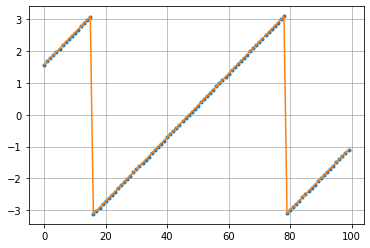

In [41]:
plt.figure()
plt.grid()
plt.plot(all_theta, '.')
plt.plot(all_theta)



We know the rate of change of $\theta$ is proportional to $\delta$. Can you work out the sequence of $\delta$ to change $\theta$ as in the cubic polynomial shown above?

In [42]:
theta_dot = np.diff(poly_turn(np.pi/2, 0)) #Assumption : taking a right turn 
v= 1; L=1
delta = np.arctan(L*theta_dot/v) 

print(delta)


[-0.05381617 -0.14337615 -0.20604245 -0.24290103 -0.25504425 -0.24290103
 -0.20604245 -0.14337615 -0.05381617]


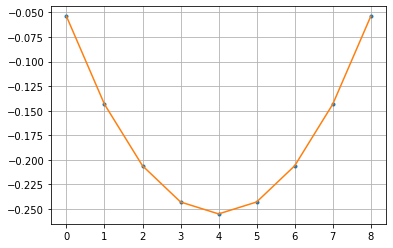

In [43]:
plt.figure()
plt.grid()
plt.plot(delta, '.')
plt.plot(delta)